# Data Structuring and Pruning

In [665]:
# Load datasets

import json
import pathlib
import importlib
from collections import defaultdict, Counter
import pyupset as pyu
import pandas as pd

import viccdb
%matplotlib inline

In [666]:
# reload module and load data
importlib.reload(viccdb)
vdb = viccdb.ViccDb()
vdb.report_groups()

brca: 5717 (25.3% of total)
cgi: 1073 (4.7% of total)
civic: 3340 (14.8% of total)
jax: 5754 (25.4% of total)
molecularmatch: 2085 (9.2% of total)
oncokb: 4048 (17.9% of total)
pmkb: 600 (2.7% of total)
22617 total associations


In [667]:
# for now, omit brca from analysis
brca = vdb.select(lambda x: x['source'] == 'brca')
core_vdb = vdb - brca
core_vdb.report_groups()

cgi: 1073 (6.3% of total)
civic: 3340 (19.8% of total)
jax: 5754 (34.0% of total)
molecularmatch: 2085 (12.3% of total)
oncokb: 4048 (24.0% of total)
pmkb: 600 (3.6% of total)
16900 total associations


In [668]:
# remove biological associations
oncokb_biological = core_vdb.select(lambda x: x['source'] == 'oncokb' and 'biological' in x['raw'])
oncokb_biological.report_groups(core_vdb)
core_vdb = core_vdb - oncokb_biological

oncokb: 3801 (93.9% of superset)
Total: 3801 (22.5% of superset)


## Evidence Uniqueness

This section deals with non-unique entries from the database. This is a temporary measure until the importers are fixed. As such, it uses private variables and non-standard methods to hack around the built-in uniqueness assumptions that are violated by these data. Remove this entire section once the source hash checks pass.

In [669]:
core_vdb.report_groups()

cgi: 1073 (8.2% of total)
civic: 3340 (25.5% of total)
jax: 5754 (43.9% of total)
molecularmatch: 2085 (15.9% of total)
oncokb: 247 (1.9% of total)
pmkb: 600 (4.6% of total)
13099 total associations


In [670]:
# Non-unique raw entries
raw_duplicates = core_vdb.select(lambda x: len(core_vdb._hashed[hash(x)]) > 1)
raw_duplicates.report_groups(core_vdb)

cgi: 2 (0.2% of superset)
pmkb: 311 (51.8% of superset)
Total: 313 (2.4% of superset)


In [671]:
cgi_dups = raw_duplicates.by_source('cgi')
cgi_clean = [x for x in cgi_dups if x['raw']['Drug status']]
test = viccdb.ViccDb([x for x in core_vdb if x not in cgi_dups] + list(cgi_clean))
test.report_groups(core_vdb)

cgi: 1072 (99.9% of superset)
civic: 3340 (100.0% of superset)
jax: 5754 (100.0% of superset)
molecularmatch: 2085 (100.0% of superset)
oncokb: 247 (100.0% of superset)
pmkb: 600 (100.0% of superset)
Total: 13098 (100.0% of superset)


In [672]:
# Test matches expectation, moving to core
core_vdb = test

In [673]:
pmkb_dups = raw_duplicates.by_source('pmkb')

In [674]:
len(pmkb_dups._hashed)

82

In [675]:
len(pmkb_dups)

311

In [676]:
merged_associations = list()
for hash_key, equivalent_associations in pmkb_dups._hashed.items():
    root_association = equivalent_associations.pop()
    for other_association in equivalent_associations:
        root_association['features'].append(other_association['features'][0])
    merged_associations.append(root_association)

In [677]:
test = viccdb.ViccDb([x for x in core_vdb if x not in merged_associations] + list(merged_associations))
test.report_groups(core_vdb)

cgi: 1072 (100.0% of superset)
civic: 3340 (100.0% of superset)
jax: 5754 (100.0% of superset)
molecularmatch: 2085 (100.0% of superset)
oncokb: 247 (100.0% of superset)
pmkb: 371 (61.8% of superset)
Total: 12869 (98.3% of superset)


In [678]:
x = len(core_vdb.by_source('pmkb')) - len(pmkb_dups) + len(pmkb_dups._hashed)
print("Expecting {} associations for PMKB".format(x))

Expecting 371 associations for PMKB


In [679]:
# Test matches expectation, moving to core
core_vdb = test

## Evidence filtering

Removal of all evidence without associated publications, followed by removal of all associations without evidence.

In [680]:
def clean_refs(association):
    evidences = association['association']['evidence']
    evidence_indices_to_delete = list()
    for i, evidence in enumerate(evidences):
        assert isinstance(publications, list)
        publications = [x for x in evidence['info']['publications'] if x]
        evidence['info']['publications'] = publications
        if not publications:
            evidence_indices_to_delete.append(i)
    for index in sorted(evidence_indices_to_delete, reverse=True):
        del association['association']['evidence'][index]

map(clean_refs, core_vdb)
core_missing_ref = core_vdb.select(lambda x: not any(x.publications))
core_missing_ref.report_groups(core_vdb)
core_vdb = core_vdb - core_missing_ref

jax: 8 (0.1% of superset)
molecularmatch: 5 (0.2% of superset)
Total: 13 (0.1% of superset)


In [681]:
core_vdb.report_groups()

cgi: 1072 (8.3% of total)
civic: 3340 (26.0% of total)
jax: 5746 (44.7% of total)
molecularmatch: 2080 (16.2% of total)
oncokb: 247 (1.9% of total)
pmkb: 371 (2.9% of total)
12856 total associations


## Feature coordinates

What follows is a detailed look at associations without start and end coordinates after normalization, and a set of regular expression filters to separate out these associations into chunks that can be annotated with gene- or exon-level coordinates, as appropriate.

In [682]:
# Associations with more than 1 feature
x = core_vdb.select(lambda x: len(x.features) > 1)
x.report_groups(vdb)

cgi: 225 (21.0% of superset)
jax: 1789 (31.1% of superset)
molecularmatch: 17 (0.8% of superset)
oncokb: 35 (0.9% of superset)
pmkb: 82 (13.7% of superset)
Total: 2148 (9.5% of superset)


In [683]:
# Associations without at least 1 complete feature
no_features = core_vdb.select(lambda x: len(x.features) == 0)
no_features.report_groups(vdb)

cgi: 4 (0.4% of superset)
civic: 3 (0.1% of superset)
jax: 12 (0.2% of superset)
molecularmatch: 17 (0.8% of superset)
oncokb: 4 (0.1% of superset)
pmkb: 2 (0.3% of superset)
Total: 42 (0.2% of superset)


In [684]:
vdb[0]['association']['phenotype']

{'description': 'lung adenocarcinoma',
 'family': 'lung cancer',
 'type': {'id': 'DOID:3910',
  'source': 'http://purl.obolibrary.org/obo/doid',
  'term': 'lung adenocarcinoma'}}

In [685]:
# Associations with coordinate features
coord_featured = core_vdb - no_features
coord_featured.report_groups(core_vdb)

cgi: 1068 (99.6% of superset)
civic: 3337 (99.9% of superset)
jax: 5734 (99.8% of superset)
molecularmatch: 2063 (99.2% of superset)
oncokb: 243 (98.4% of superset)
pmkb: 369 (99.5% of superset)
Total: 12814 (99.7% of superset)


### Remainder of section is inactivated code for identifying associations without coordinates

import re

def feature_filter(re_obj, associations):
    # report matches and return non-matches
    found = list(filter(lambda x: re_obj.search(x['feature_names']) is not None, associations))
    not_found = list(filter(lambda x: re_obj.search(x['feature_names']) is None, associations))
    report_groups(found)
    return(not_found)

amp_re = re.compile(r'(amplification)|(loss)|(amp)', re.IGNORECASE)
remainder = feature_filter(amp_re, no_partial_coord_featured_with_feature_names)

fusion_re = re.compile(r'(\w{2,}-\w{2,})|(fusion)', re.IGNORECASE)
r2 = feature_filter(fusion_re, remainder)

ppm_re = re.compile(r'\w+(:| )[a-z]\d+[a-z]?(fs\*?)?$', re.IGNORECASE)
r3 = feature_filter(ppm_re, r2)

indel_re = re.compile(r'\w+(:| )\w+(ins\w+)|(del($|ins\w+))|(dup$)')
r4 = feature_filter(indel_re, r3)

bucket_re = re.compile(r'[A-Z0-9]+( (in)?act)?( oncogenic)? mut((ant)|(ation))?$')
r5 = feature_filter(bucket_re, r4)

exon_re = re.compile(r'exon', re.IGNORECASE)
r6 = feature_filter(exon_re, r5)

expression_re = re.compile(r'(exp)|(^\w+ (pos(itive)?)|(neg(ative)?)|(biallelic inactivation)$)|(truncating)|(deletion)', re.IGNORECASE)
r7 = feature_filter(expression_re, r6)

report_groups(r7)

get_feature_names([x for x in r7 if x['source'] == 'cgi'])

## Diseases

In [686]:
disease_missing = core_vdb.select(lambda x: x.disease is None)
disease_missing.report_groups(core_vdb)

civic: 1 (0.0% of superset)
Total: 1 (0.0% of superset)


In [687]:
disease_missing[0]['association']

{'description': 'Pericytoma with t(7;12) is a soft tissue tumor characterized by fusion of the ACTB and GLI genes through the translocation t(7;12)(p22;q13). In this study the genomic breakpoints of 5 cases were characterized.',
 'environmentalContexts': [],
 'evidence': [{'description': 'Positive',
   'evidenceType': {'id': '1844', 'sourceName': 'CIVIC'},
   'info': {'publications': ['http://www.ncbi.nlm.nih.gov/pubmed/15555571']}}],
 'evidence_label': 'B',
 'evidence_level': 2,
 'phenotype': {'description': 'Pericytoma',
  'family': 'Uncategorized-PHN',
  'id': 'http://www.disease-ontology.org/'},
 'publication_url': ['http://www.ncbi.nlm.nih.gov/pubmed/15555571'],
 'response_type': 'Positive',
 'source_link': 'https://civic.genome.wustl.edu/events/genes/2279/summary/variants/780/summary'}

## Drugs

In [688]:
drugs_missing = core_vdb.select(lambda x: len(x.drugs) == 0)
drugs_missing.report_groups(core_vdb)

cgi: 112 (10.4% of superset)
civic: 1261 (37.8% of superset)
jax: 457 (8.0% of superset)
molecularmatch: 120 (5.8% of superset)
oncokb: 8 (3.2% of superset)
pmkb: 371 (100.0% of superset)
Total: 2329 (18.1% of superset)


## Cache

Saving core_vdb to cache for testing.

In [689]:
core_vdb.cache_data()

# Knowledgebase Comparison

## Publications

### All publications

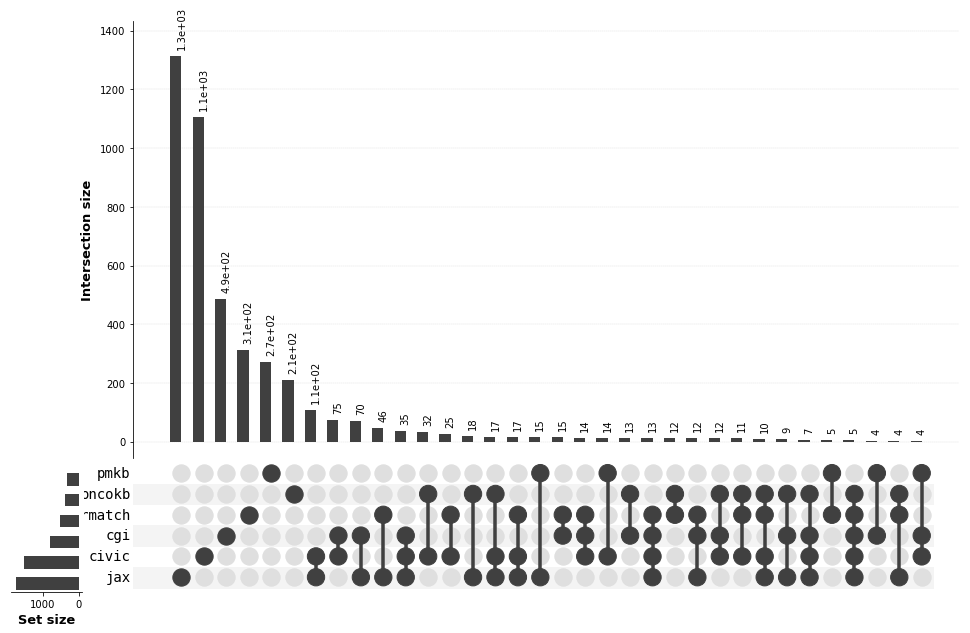

In [690]:
x = core_vdb.plot_element_by_source('publications', min_bound=4)
# f = x['figure']
# f.savefig('out/publications.pdf')

In [691]:
# Publications uniquely cited
data = x['input_data']
total = 0
for source in data:
    publications_from_elsewhere = set()
    for source2 in data:
        if source == source2:
            continue
        publications_from_elsewhere.update(data[source2])
    unique = data[source] - publications_from_elsewhere
    print("{}: {} resource-specific publications".format(source, len(unique)))
    total += len(unique)
print("{} ({:.2%}) total resource-specific publications".format(total, total / len(set.union(*(data.values())))))

molecularmatch: 311 resource-specific publications
civic: 1106 resource-specific publications
pmkb: 272 resource-specific publications
oncokb: 211 resource-specific publications
jax: 1312 resource-specific publications
cgi: 486 resource-specific publications
3698 (84.89%) total resource-specific publications


In [692]:
all_cited = set.intersection(*(data.values()))
all_pubs = set.union(*(data.values()))
print("{}/{} ({:.2%}) publication cited across all resources".format(len(all_cited), len(all_pubs),
                                                                     len(all_cited) / len(all_pubs)))

1/4356 (0.02%) publication cited across all resources


In [693]:
print(all_cited) # Bose et al. Cancer Discovery 2013
all_size = len(all_pubs)

{<class 'viccdb.Publication'>: 23220880}


In [694]:
# >=3x coverage
count = Counter()
for source in data:
    count.update(data[source])
high_coverage_publications = [x for x in count if count[x] >= 3]
hc_size = len(high_coverage_publications)
print("{} / {} ({:.2%}) of publications are represented by at least 3 resources.".format(hc_size, all_size,
                                                                                  hc_size / all_size))

203 / 4356 (4.66%) of publications are represented by at least 3 resources.


### PMIDs

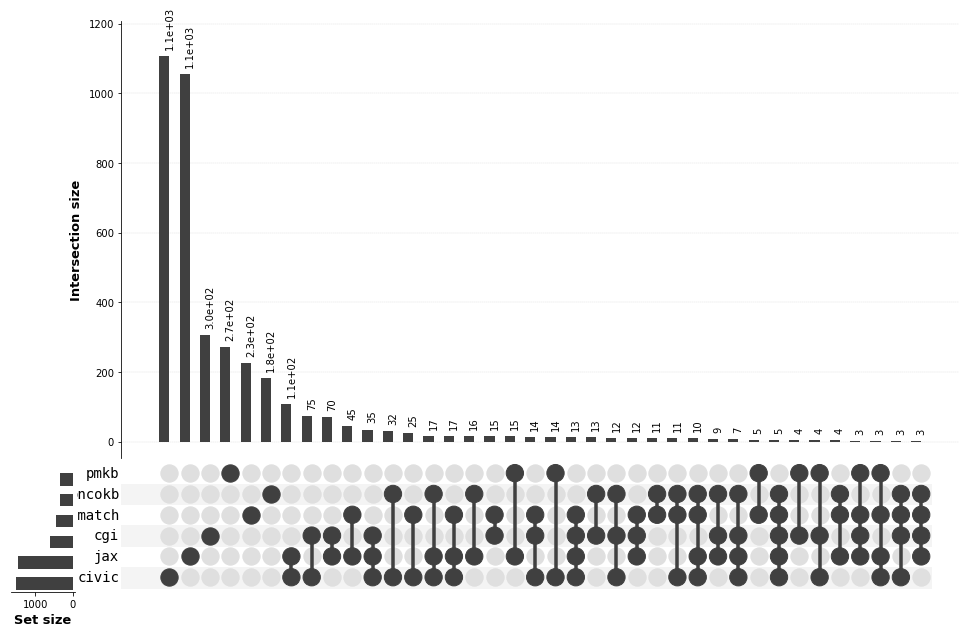

In [695]:
x = core_vdb.plot_element_by_source('publications', lambda x: x.pmid, min_bound=3)
# f = x['figure']
# f.savefig('out/pmids.pdf')

## Genes

In [696]:
no_genes = core_vdb.select(lambda x: x['genes'] == [''])
no_genes.report_groups(core_vdb)

molecularmatch: 3 (0.1% of superset)
Total: 3 (0.0% of superset)


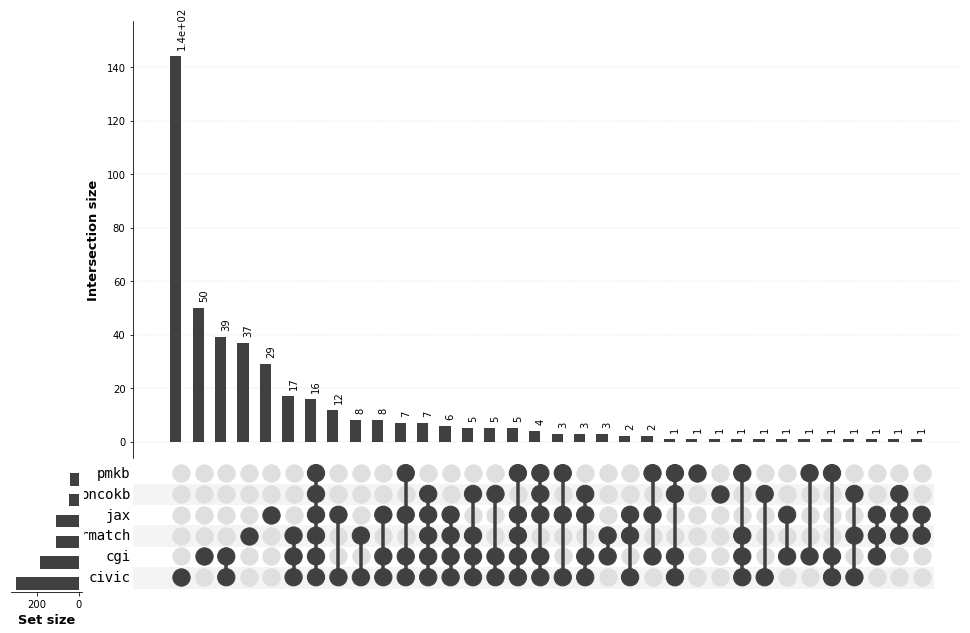

In [697]:
with_genes = core_vdb - no_genes
x = with_genes.plot_element_by_source('genes')
# f = x['figure']
# f.savefig('out/genes.pdf')

In [698]:
x = with_genes.element_by_source_stats('genes')
x['ubiquitous']

262 / 424 (61.79%) of genes are represented in only 1 resource.
96 / 424 (22.64%) of genes are represented in the majority of (3) resources.
16 / 424 (3.77%) of genes are represented across all resources.


{<class 'viccdb.Gene'>: ABL1,
 <class 'viccdb.Gene'>: ALK,
 <class 'viccdb.Gene'>: BRAF,
 <class 'viccdb.Gene'>: EGFR,
 <class 'viccdb.Gene'>: ERBB2,
 <class 'viccdb.Gene'>: FGFR2,
 <class 'viccdb.Gene'>: FGFR3,
 <class 'viccdb.Gene'>: FLT3,
 <class 'viccdb.Gene'>: KIT,
 <class 'viccdb.Gene'>: KRAS,
 <class 'viccdb.Gene'>: MET,
 <class 'viccdb.Gene'>: NOTCH1,
 <class 'viccdb.Gene'>: NRAS,
 <class 'viccdb.Gene'>: PDGFRA,
 <class 'viccdb.Gene'>: PIK3CA,
 <class 'viccdb.Gene'>: PTEN}

## Features

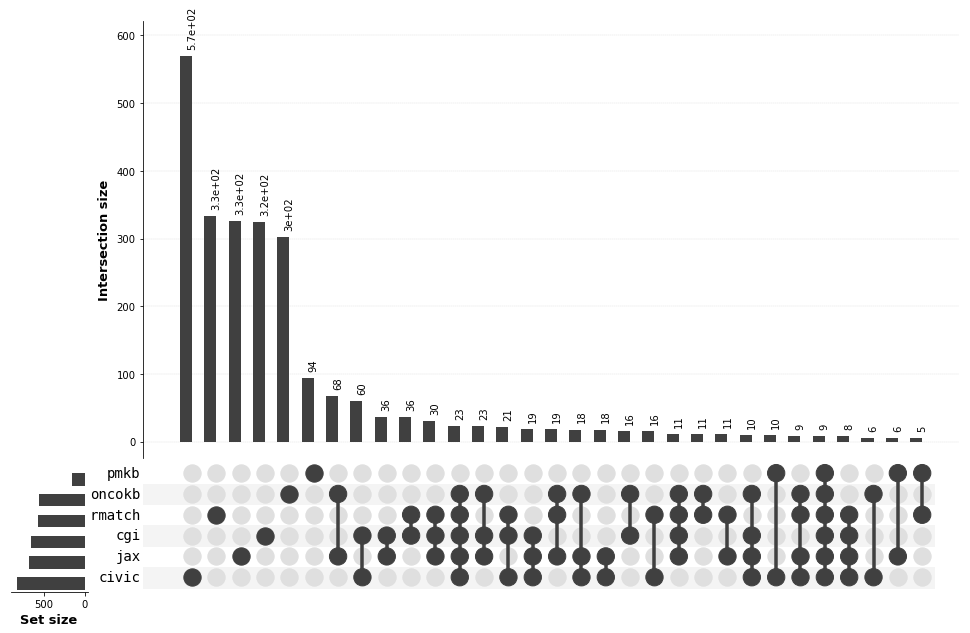

In [699]:
x = core_vdb.plot_element_by_source('features', min_bound=5)
# f = x['figure']
# f.savefig('out/features.pdf')

In [700]:
x = with_genes.element_by_source_stats('features')

1947 / 2496 (78.00%) of features are represented in only 1 resource.
245 / 2496 (9.82%) of features are represented in the majority of (3) resources.
9 / 2496 (0.36%) of features are represented across all resources.


### Sequence Ontology

In [616]:
count = Counter()
for association in core_vdb:
    for feature in association.features:
        count[feature.so.get('name', 'Uncategorized')] += 1

In [617]:
count.most_common(10)

[('Uncategorized', 8310),
 ('missense_variant', 2986),
 ('fusion', 2071),
 ('stop_gained', 1727),
 ('substitution', 1244),
 ('feature_amplification', 440),
 ('wild_type', 391),
 ('loss_of_function_variant', 242),
 ('copy_number_loss', 207),
 ('positively_autoregulated', 197)]

In [618]:
(5052 + 3263) / sum(count.values())

0.4256462759150243

In [619]:
# Associations lacking any sequence ontology ID

def no_soid(association):
    x = [feature.so.get('name', 'Uncategorized') == 'Uncategorized' for feature in association.features]
    return all(x)

no_soid_group = core_vdb.select(no_soid)
no_soid_group.report_groups(core_vdb)

cgi: 523 (48.8% of superset)
civic: 373 (11.2% of superset)
jax: 2302 (40.1% of superset)
molecularmatch: 449 (21.6% of superset)
oncokb: 78 (31.6% of superset)
pmkb: 110 (29.6% of superset)
Total: 3835 (29.8% of superset)


In [620]:
# Associations lacking at least one sequence ontology ID

def missing_soid(association):
    x = [feature.so.get('name', 'Uncategorized') == 'Uncategorized' for feature in association.features]
    return any(x)

missing_soid_group = core_vdb.select(missing_soid)
missing_soid_group.report_groups(core_vdb)

cgi: 519 (48.4% of superset)
civic: 370 (11.1% of superset)
jax: 3123 (54.4% of superset)
molecularmatch: 433 (20.8% of superset)
oncokb: 74 (30.0% of superset)
pmkb: 108 (29.1% of superset)
Total: 4627 (36.0% of superset)


In [621]:
partial_soid_group = missing_soid_group - no_soid_group
partial_soid_group.report_groups(core_vdb)

jax: 833 (14.5% of superset)
molecularmatch: 1 (0.0% of superset)
Total: 834 (6.5% of superset)


In [622]:
partial_soid_group[0].features[2].so

{'hierarchy': ['SO:0000110', 'SO:0002072', 'SO:0001059', 'SO:0000248'],
 'name': 'copy_number_variation',
 'parent_name': 'sequence_feature',
 'parent_soid': 'SO:0000110',
 'soid': 'SO:0001019'}